In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This dataset has just over 500,000 rows - to make these notebooks run a bit more quickly, I use 100,000 rows at most. This still offers plenty of post authors!

In [3]:
df = pd.read_csv('gdrive/My Drive/reddit_worldnews_start_to_2016-11-22.csv')[:100000]

df.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,subreddit
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [4]:
df.author.value_counts().head(20)

igeldard            3918
twolf1              1799
maxwellhill         1644
SolInvictus         1581
DougBolivar         1321
galt1776            1266
DrRichardCranium    1214
alllie               947
davidreiss666        940
blackstar9000        696
Kaffir               671
koavf                648
MrTulip              607
Orangutan            589
silence_hr           587
mjanes               556
jips                 544
misterAction         529
spainguy             482
ajehals              446
Name: author, dtype: int64

A few simple preprocessing steps, wrapped in a function so that they are replicable in future notebooks: exclude authors posting below a certain threshold, lowercase our text, and compute a couple new fields to be used later on. We'll return both the tranformed original dataframe and a new dataframe grouped by user with all text joined.

In [0]:
def _preprocess(df, min_posts=10):
  exclude_authors = df.groupby("author").count()
  exclude_authors = exclude_authors[exclude_authors.title <= min_posts].index.values
  
  df = df[~df.author.isin(exclude_authors)]

  df['title'] = df.title.str.lower()
  df['score'] = df.up_votes - df.down_votes

  df_grouped = df.groupby('author')['title'].apply(lambda x: ' '.join(x)).reset_index()
  df_grouped['mean_score'] = df.groupby('author')['score'].mean().values

  df_grouped['score_category'] = np.where(df_grouped.mean_score >= np.mean(df_grouped.mean_score) + np.std(df_grouped.mean_score),
                                        'high_scorer',
                                        np.where(df_grouped.mean_score <= np.mean(df_grouped.mean_score) - 10,
                                                 'low_scorer','mid_scorer')
                                        )
  
  return df, df_grouped

In [6]:
df_preprocessed, df_grouped = _preprocess(df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Now we'll train a word2vec model using gensim. We'll give it 1024 dimensions, because this is the size of the LASER vectors we'll use later.

In [0]:
from gensim.models import Word2Vec

text = [t for t in df_preprocessed.title]

model = Word2Vec(text, size=1024, window=5, sg=1)

To compute author-level vectors, take the average vector for all of the author's posts. This approach works well for individual documents, but I haven't seen a good example of a case like this where our unit of analysis isn't individual documents.

In [0]:
def doc_vectorizer(text, model):
  doc_vec = 0
  count = 0

  if len(text) == 1:
    return model[text]

  for t in text:
    try:
      word_vec = model[t]
      doc_vec = doc_vec + word_vec
      count += 1
    except:
      pass
  
  doc_vec = doc_vec / count
  return doc_vec

In [9]:
author_vectors = [doc_vectorizer(t.lower(), model) for t in df_grouped.title]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


T-SNE is useful for reducing the dimensions of the vectors for visualization, and it's most stable if combined with PCA as seen here.

Since this isn't a dataset with obvious clusters, the absence of clear clusters in the plot doesn't mean this isn't working!

The points in the plot are labeled by the user's average upvote/downvote score - maybe users who get many upvotes are different in some way from users who don't?

In [0]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca')
tsne_results = tsne.fit_transform(author_vectors)

df_grouped['tsne_x'] = tsne_results[:,0]
df_grouped['tsne_y'] = tsne_results[:,1]

In [11]:
df_grouped.score_category.value_counts()

low_scorer     741
mid_scorer     392
high_scorer    124
Name: score_category, dtype: int64

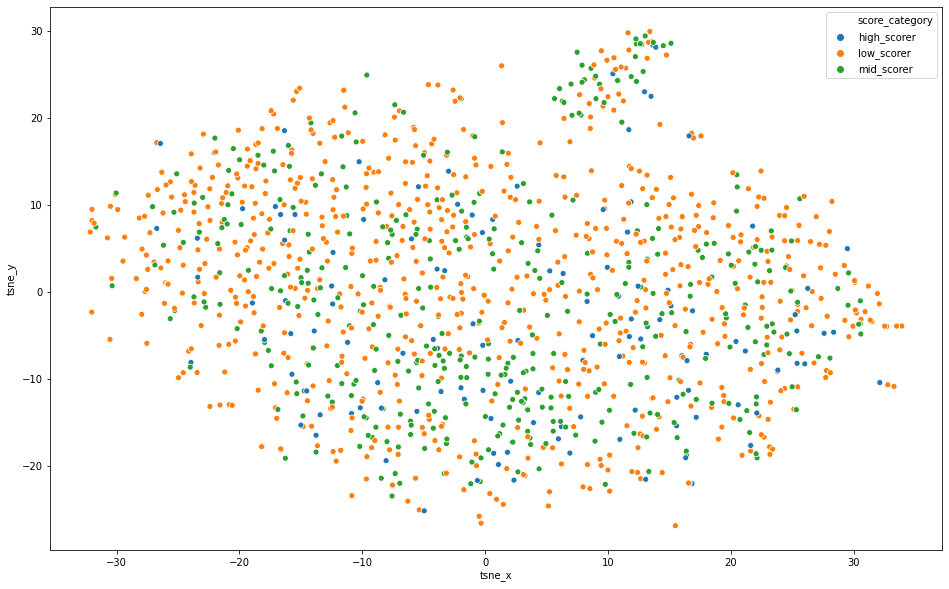

In [12]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='tsne_x', y='tsne_y',
    hue="score_category",
    data=df_grouped,
    legend="full")

There might be a bit of a cluster near the peak of the y-axis, but otherwise this isn't showing us much.

As another measure of performance, let's get the five most similar authors for the first five authors in the dataset using both cosine distance and FAISS. Cosine distance has been show to give better results that euclidean distance in high dimensional space, and [FAISS](https://github.com/facebookresearch/faiss) is a library by Facebook that is specifically designed for similarity searches.

In [0]:
from sklearn.metrics.pairwise import cosine_distances

author_distances = pd.DataFrame(
    cosine_distances(author_vectors, author_vectors)
)

In [14]:
#Authors will obviously be exactly similar to themselves
author_distances_v2 = author_distances.replace(0, np.nan)
author_distances_v2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1217,1218,1219,1220,1221,1222,1223,1224,1225,1226,1227,1228,1229,1230,1231,1232,1233,1234,1235,1236,1237,1238,1239,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256
0,NaN,0.001322,0.002060,0.001206,0.001522,0.002121,0.001221,0.001424,0.001291,0.001815,0.001979,0.001291,0.001268,0.001102,0.001964,0.001760,0.001573,0.001179,0.002353,0.001953,0.002610,0.001029,0.001503,0.001621,0.001403,0.001653,0.001258,0.001096,0.001483,0.001931,0.001708,0.000791,0.001535,0.001756,0.001419,0.001164,0.001685,0.001011,0.001439,0.001078,...,0.001273,0.001144,0.001551,0.001368,0.000690,0.001122,0.002306,0.001448,0.001563,0.002191,0.002206,0.001357,0.001595,0.001112,0.001904,0.001623,0.001217,0.001540,0.001376,0.002312,0.001444,0.001868,0.001892,0.001263,0.001338,0.001052,0.001358,0.002261,0.000755,0.000982,0.002860,0.001465,0.000928,0.001537,0.001046,0.001505,0.001749,0.001102,0.000874,0.001221
1,0.001322,NaN,0.002639,0.001188,0.002660,0.002764,0.001888,0.001817,0.002327,0.001776,0.001752,0.002283,0.001845,0.001546,0.001875,0.003031,0.002372,0.001488,0.003386,0.002989,0.003505,0.000837,0.001408,0.001543,0.001928,0.002687,0.001694,0.001408,0.002331,0.002498,0.002953,0.000688,0.002041,0.002016,0.001596,0.001744,0.002011,0.001535,0.001635,0.001232,...,0.000934,0.001548,0.002449,0.001520,0.001080,0.001056,0.003221,0.002078,0.002200,0.002642,0.002980,0.001557,0.002038,0.001708,0.002832,0.002107,0.001457,0.001674,0.001941,0.003149,0.001355,0.002688,0.002117,0.001624,0.001329,0.002176,0.001895,0.003040,0.001050,0.000897,0.003928,0.002252,0.000772,0.002038,0.001698,0.001764,0.001939,0.001551,0.000613,0.001619
2,0.002060,0.002639,NaN,0.000662,0.000432,0.000516,0.000686,0.001618,0.000461,0.001273,0.000354,0.000322,0.000216,0.000283,0.000518,0.002383,0.000178,0.000578,0.000982,0.000257,0.000349,0.000745,0.000384,0.000452,0.000164,0.000772,0.000184,0.000734,0.000376,0.000165,0.000487,0.001255,0.000213,0.000225,0.000418,0.000268,0.000127,0.000491,0.001527,0.000916,...,0.000880,0.000385,0.000287,0.000460,0.001667,0.000801,0.001033,0.000191,0.000144,0.000116,0.000225,0.000665,0.000172,0.000726,0.000281,0.000177,0.000451,0.000285,0.000450,0.000797,0.000481,0.000325,0.000393,0.000219,0.000467,0.000905,0.000536,0.000284,0.000711,0.001271,0.000914,0.000223,0.001449,0.000257,0.000304,0.000346,0.000247,0.000589,0.000978,0.000245
3,0.001206,0.001188,0.000662,NaN,0.000748,0.001184,0.000632,0.000945,0.000741,0.000941,0.000460,0.000682,0.000482,0.000381,0.000450,0.001631,0.000572,0.000393,0.001239,0.001056,0.001107,0.000381,0.000354,0.000657,0.000370,0.000579,0.000339,0.000556,0.000872,0.000633,0.001017,0.000573,0.000549,0.000464,0.000226,0.000290,0.000373,0.000470,0.000722,0.000459,...,0.000486,0.000460,0.000664,0.000511,0.000682,0.000513,0.000938,0.000552,0.000533,0.000755,0.000680,0.000443,0.000392,0.000491,0.000999,0.000480,0.000356,0.000460,0.000724,0.001196,0.000489,0.000679,0.000521,0.000324,0.000544,0.000644,0.000603,0.001106,0.000254,0.000429,0.001293,0.000425,0.000720,0.000709,0.000322,0.000528,0.000592,0.000421,0.000396,0.000333
4,0.001522,0.002660,0.000432,0.000748,NaN,0.001175,0.000685,0.001826,0.000221,0.001437,0.000808,0.000551,0.000339,0.000436,0.000878,0.002108,0.000346,0.000529,0.001076,0.000458,0.000598,0.000894,0.000606,0.000867,0.000325,0.000455,0.000307,0.000876,0.000620,0.000405,0.000608,0.000993,0.000569,0.000493,0.000578,0.000455,0.000364,0.000597,0.001535,0.000779,...,0.001173,0.000529,0.000425,0.000697,0.001298,0.001055,0.001091,0.000383,0.000358,0.000631,0.000264,0.000699,0.000533,0.000795,0.000637,0.000392,0.000778,0.000716,0.000833,0.000968,0.000761,0.000608,0.000835,0.000420,0.000810,0.000696,0.000713,0.000558,0.000853,0.001042,0.001270,0.000281,0.001471,0.000614,0.000270,0.000548,0.000775,0.000785,0.001037,0.000329


In [15]:
most_similar_cosine = pd.DataFrame()

for i, row in author_distances_v2.head().iterrows():
  most_similar = np.argsort(row.values)[:4]
  most_similar_authors = []
  for s in most_similar:
    author = str(df_grouped.author[s])
    most_similar_authors.append(author)
  most_similar_i = pd.DataFrame({'original':df_grouped.author[i], 'most_similar':', '.join(most_similar_authors)}, index=[0])
  most_similar_cosine = most_similar_cosine.append(most_similar_i)

most_similar_cosine

,original,most_similar
0,000078754,"florence25, marcpk, dreams16, tefster"
0,007simple,"goghi, coffinman82, charlatan, Dhghomon"
0,00boyina,"geekchic, chefranden, silence_hr, viborg"
0,02116663ag,"IntolerantFaith, NagastaBagamba, sohail, stubble"
0,0boy,"gtfonline, rastawala, sea_wall, ajehals"


Maybe FAISS gives better similarity 

You'll need to install the cpu version of FAISS, and the next few cells are adapted from [this tutorial](#https://github.com/facebookresearch/faiss/blob/master/tutorial/python/1-Flat.py) on the basics of FAISS.

In [16]:
!pip install faiss-cpu --no-cache

FAISS requires that you separate your vectors into a database and a query.
Then you build an index, and add your database to that index as a single float32 vector.

In [0]:
query_vectors = author_vectors[:5]
database_vectors = author_vectors[5:]

In [18]:
import faiss      

vector_size = 1024                                      
             
index = faiss.IndexFlatL2(vector_size) 
print(index.is_trained)

True


In [19]:
database_vector = np.array(database_vectors, dtype='float32')
query_vector = np.array(query_vectors, dtype='float32')
index.add(database_vector)                 
print(index.ntotal)

1252


In [20]:
pd.set_option('display.max_colwidth', 100)

#The search method searches for the n nearest vectors to the query vector
distance, sim_index = index.search(query_vector, 4)

most_similar_faiss = pd.DataFrame()

for i in range(5):
  most_similar_authors = []
  for s in sim_index[i]:
    author = str(df_grouped.author[s])
    most_similar_authors.append(author)
  most_similar_i = pd.DataFrame({'original':df_grouped.author[i], 'most_similar':', '.join(most_similar_authors)}, index=[0])
  most_similar_faiss = most_similar_faiss.append(most_similar_i)

most_similar_faiss

,original,most_similar
0,000078754,"fishbert, dougmataconis, madonix, C2hristina"
0,007simple,"clacla83, glcarlstrom, casualfactors, XKingKong"
0,00boyina,"garyp714, cfall123, shravanmishra, vanibahl"
0,02116663ag,"ImJulianAssange, MrXfromPlanetX, smag1985, steppenwolf86"
0,0boy,"gregwont, rajsaxena, saute, aenea"


In [0]:
df_preprocessed.to_csv('gdrive/My Drive/reddit_preprocessed.csv')
df_grouped.to_csv('gdrive/My Drive/reddit_grouped.csv')